#**MMM Modeling with Mediation Assumption**

Build and document a machine learning model using a 2-year weekly dataset containing paid media metrics, direct response
levers (email/SMS), price, followers, promotions, and revenue that explains Revenue as
a function of the input variables.

### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

### 1. Understanding And Cleaning the data

In [6]:
import zipfile
import pandas as pd

# Specify the path to the zip file
zip_file_path = '/content/drive/MyDrive/Assessment 2 - MMM Weekly.csv.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get a list of files in the zip archive
    file_list = zip_ref.namelist()

    # Assume the CSV file we want is the one without the __MACOSX prefix
    csv_file_name = [f for f in file_list if not f.startswith('__MACOSX')][0]

    # Extract the desired CSV file
    zip_ref.extract(csv_file_name, '/tmp') # Extract to a temporary directory

# Construct the full path to the extracted CSV file
extracted_csv_path = f'/tmp/{csv_file_name}'

# Import the Dataset from the extracted CSV file
df = pd.read_csv(extracted_csv_path)
df.head()

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [7]:
# Check the datatypes and for null entries
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   week              104 non-null    object 
 1   facebook_spend    104 non-null    float64
 2   google_spend      104 non-null    float64
 3   tiktok_spend      104 non-null    float64
 4   instagram_spend   104 non-null    float64
 5   snapchat_spend    104 non-null    float64
 6   social_followers  104 non-null    int64  
 7   average_price     104 non-null    float64
 8   promotions        104 non-null    int64  
 9   emails_send       104 non-null    int64  
 10  sms_send          104 non-null    int64  
 11  revenue           104 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 9.9+ KB


,0
week,0
facebook_spend,0
google_spend,0
tiktok_spend,0
instagram_spend,0
snapchat_spend,0
social_followers,0
average_price,0
promotions,0
emails_send,0


In [8]:
# Convert 'week' column to datetime objects.
df['week'] = pd.to_datetime(df['week'])

In [9]:
# Create a trend feature as a simple numerical index.
df['trend'] = np.arange(len(df)) + 1

In [10]:
# Create a seasonality feature (week of the year).
df['week_of_year'] = df['week'].dt.isocalendar().week.astype(int)

In [11]:
# Identify paid media and direct response columns for feature engineering.
paid_media_cols = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
direct_response_cols = ['emails_send', 'sms_send']
other_features = ['average_price', 'promotions', 'social_followers', 'trend', 'week_of_year']

In [12]:
# Apply log transformation to handle zero-spend periods and diminishing returns,and scale the other skewed features.
for col in paid_media_cols + direct_response_cols:
    df[f'log_{col}'] = np.log1p(df[col])

In [13]:
# Combine all final features into a single list.
features = [f'log_{col}' for col in paid_media_cols] + [f'log_{col}' for col in direct_response_cols] + other_features

In [14]:
# Define the target variable.
target = 'revenue'

In [15]:
# Handle potential zeros in revenue and apply log transformation.
df['log_revenue'] = np.log1p(df[target])

### 2. Model Building

In [16]:
# Separate features (X) and target (y).
X = df[features]
y_revenue = df['log_revenue']
y_google = df['log_google_spend']

In [17]:
# Scale the features using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### 3.Causal Framing (Two-Stage Modeling)

In [18]:
# Stage 1: Model log_google_spend as a function of social media spend.
# This explicitly treats Google as a mediator.
social_features = [f'log_{col}' for col in ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']]
X_social = X_scaled[social_features]

In [19]:
# Use a Lasso model for Stage 1.
lasso_google = Lasso(alpha=0.1)
lasso_google.fit(X_social, y_google)
df['predicted_log_google_spend'] = lasso_google.predict(X_social)

In [20]:
# Add the predicted google spend to the main feature set for Stage 2.
X_stage2 = X_scaled.drop(columns=['log_google_spend'])
X_stage2['predicted_log_google_spend'] = df['predicted_log_google_spend']

###4. Model Training and Validation

In [21]:
# Use a TimeSeriesSplit to avoid data leakage (look-ahead bias).
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
print("\n--- Training Model with TimeSeriesSplit ---")
for train_index, test_index in tscv.split(X_stage2):
    X_train, X_test = X_stage2.iloc[train_index], X_stage2.iloc[test_index]
    y_train, y_test = y_revenue.iloc[train_index], y_revenue.iloc[test_index]

    lasso_revenue = Lasso(alpha=0.1)
    lasso_revenue.fit(X_train, y_train)
    y_pred = lasso_revenue.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Split RMSE: {rmse:.4f}, R-squared: {r2:.4f}")


--- Training Model with TimeSeriesSplit ---
Split RMSE: 2.5966, R-squared: 0.0234
Split RMSE: 1.4615, R-squared: 0.5530
Split RMSE: 3.1234, R-squared: 0.4637
Split RMSE: 1.0406, R-squared: 0.8983
Split RMSE: 2.0321, R-squared: 0.4583


In [23]:
# Train the final model on the full dataset for final coefficients.
final_lasso_revenue = Lasso(alpha=0.1)
final_lasso_revenue.fit(X_stage2, y_revenue)

Lasso(alpha=0.1)

### 5.Diagnostics and Insights

In [24]:
print("\n--- Final Model Coefficients ---")
coefficients = pd.DataFrame({'feature': X_stage2.columns,'coefficient': final_lasso_revenue.coef_}).sort_values('coefficient', ascending=False)
print(coefficients)


--- Final Model Coefficients ---
                       feature  coefficient
2          log_instagram_spend     2.067093
5                 log_sms_send     0.582663
7                   promotions     0.041549
4              log_emails_send     0.028636
11  predicted_log_google_spend     0.000000
10                week_of_year    -0.000000
3           log_snapchat_spend    -0.000000
8             social_followers    -0.000000
0           log_facebook_spend    -0.031677
9                        trend    -0.065023
1             log_tiktok_spend    -0.427881
6                average_price    -1.421243


In [25]:
# Evaluate the model on the full dataset (for a general sense of fit)
final_predictions = final_lasso_revenue.predict(X_stage2)
final_rmse = np.sqrt(mean_squared_error(y_revenue, final_predictions))
final_r2 = r2_score(y_revenue, final_predictions)

In [26]:
print(f"\nFinal Model Performance (on full dataset):")
print(f"  RMSE: {final_rmse:.4f}")
print(f"  R-squared: {final_r2:.4f}")


Final Model Performance (on full dataset):
  RMSE: 1.8434
  R-squared: 0.6695


In [27]:
# Convert log predictions back to original scale for interpretation
results_df = df[['week', 'revenue']].copy()
results_df['predicted_revenue'] = np.expm1(final_predictions)
print("\n--- Predicted vs Actual Revenue (Head) ---")
print(results_df.head())


--- Predicted vs Actual Revenue (Head) ---
        week   revenue  predicted_revenue
0 2023-09-17  83124.16        7069.435527
1 2023-09-24    373.02         440.450967
2 2023-10-01    513.01         517.831876
3 2023-10-08    452.78         122.526849
4 2023-10-15  41441.95       17091.080436


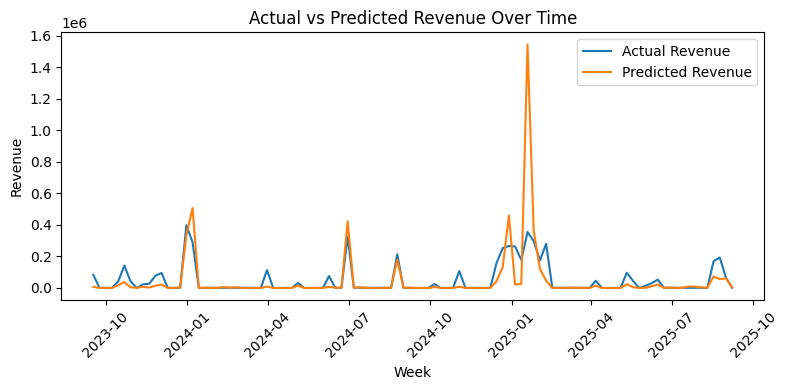

In [33]:
# Line graph of Actual vs Predicted
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))
sns.lineplot(x='week', y='revenue', data=results_df, label='Actual Revenue')
sns.lineplot(x='week', y='predicted_revenue', data=results_df, label='Predicted Revenue')
plt.title('Actual vs Predicted Revenue Over Time')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

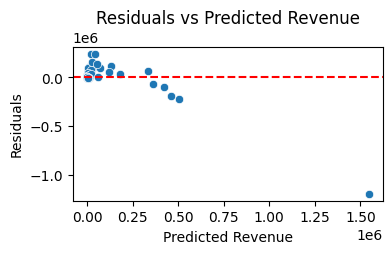

In [35]:
# Calculate residuals
results_df['residuals'] = results_df['revenue'] - results_df['predicted_revenue']

# Scatter plot of residuals vs predicted values
plt.figure(figsize=(4,2))
sns.scatterplot(x='predicted_revenue', y='residuals', data=results_df)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Revenue')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.show()